# **WRF Anlaysis: LiDAR Comparisons**
#### This notebook performs the following tasks:
> - #### Reads in WRF data as a NetCDF file using Xarray and post processes the data using xwrf.
> - #### Computes model height levels from the default eta levels in WRF using xgcm.
> - #### Identifies the nearest WRF gridpoint to particular LiDAR locations deployed in Santa Barbara County for the Sundowner Winds Experiment (2022) in 2022 as well as the Bakersfield ASOS station (KBFL).
> - #### Grabs the needed WRF variables for each nearest gridpoint to produce a vertical profile of horizontal and vertical winds.

## **Package Imports**
#### Links to documentation for packages
> - #### [pathlib](https://docs.python.org/3/library/pathlib.html) | [xwrf](https://xwrf.readthedocs.io/en/latest/) | [xgcm](https://xgcm.readthedocs.io/en/latest/) | [numpy](https://numpy.org/doc/1.21/) | [xarray](https://docs.xarray.dev/en/stable/) | [colorcet](https://colorcet.holoviz.org/) | [metpy](https://unidata.github.io/MetPy/latest/index.html) | [matplotlib](https://matplotlib.org/stable/index.html)
> - #### Documentation for packages linked above should mostly correspond to the most stable versions, which may not be the exact versions used when creating this notebook.
> - #### Comments are also included in the actual code cells. Commented links above certain pieces of code are provided to help show where some lines were copied from. It is possible that there may still be snippets of code here that were simply grabbed off the internet, from places like StackOverflow, without any atribution.

In [1]:
#----------------------------------------
#Entire packages
import pathlib
import wrf
import xwrf
import xgcm
import numpy as np
import pandas as pd
import xarray as xr

#metpy imports
import metpy.calc as mpcalc
from metpy.units import units

#NetCDF4 imports
from netCDF4 import Dataset

#matplotlib imports
import matplotlib.patheffects
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.font_manager as mplf
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#----------------------------------------

ERROR 1: PROJ: proj_create_from_database: Open of /home/sbarc/students/mariandob/mambaforge/envs/swex/share/proj failed


## **Define variables that point to paths for relevant data**
#### **Data Information**
> #### WRF Output Data
> - #### Temporal Resolution: 10-minutes
> - #### Spatial Resolution: d01: 9km | d02: 3km | d03: 1km
> - #### Lateral and Boundary Conditions: ERA5 Reanalysis
> - #### See [Jones et al. (2021)](https://www.sciencedirect.com/science/article/pii/S0169809520312424) for more information on parameterization schemes used. Although that WRF downscaling dataset is different from the one used here, the parameterization set up is the same.

In [2]:
#----------------------------------------
#Define path to WRF output files (specifically just the inner most, 1km domain, d03)
path_to_wrf_files = sorted(pathlib.Path('/home/voyager-sbarc/wrf/wrf460/sundowners/swex2022/iop10/run_1km_545_24_z107_2way/').glob('wrfout_d03*'))

#Display a path variable to make sure we have files
display(path_to_wrf_files)
#----------------------------------------

[PosixPath('/home/voyager-sbarc/wrf/wrf460/sundowners/swex2022/iop10/run_1km_545_24_z107_2way/wrfout_d03_2022-05-11_18:00:00')]

## **Read in WRF output NetCDF files using xarray and postprocess them using xwrf**
#### Notes
> - #### Depending on the spatial and temporal resolution of your files, this may take some time to run. In the cell below we do this procedure for a single domain and not all domains. This saves a little time.
> - #### See inline comments for additional details.

In [3]:
#----------------------------------------
#Read in WRF output file for each domain and use xwrf to postprocess them
wrf_d03_nc = xr.open_dataset(path_to_wrf_files[0], chunks='auto').xwrf.postprocess()

#Destagger WRF output file using xwrf
wrf_d03_nc_destaggered = wrf_d03_nc.xwrf.destagger()

#Display the destaggered WRF xarray Dataset
display(wrf_d03_nc_destaggered)
#----------------------------------------

/home/sbarc/students/mariandob/mambaforge/envs/swex/lib/python3.11/site-packages/xwrf/grid.py:64: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nx = ds.dims['west_east']
/home/sbarc/students/mariandob/mambaforge/envs/swex/lib/python3.11/site-packages/xwrf/grid.py:65: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ny = ds.dims['south_north']


<xarray.Dataset> Size: 214GB
Dimensions:                    (Time: 289, y: 234, x: 258, soil_layers: 3,
                                z: 106, seed_dim: 1, snow_layers: 2,
                                snso_layers: 6, x_stag: 259, y_stag: 235,
                                z_stag: 107)
Coordinates: (12/15)
    XLAT                       (y, x) float32 241kB dask.array<chunksize=(234, 258), meta=np.ndarray>
    XLONG                      (y, x) float32 241kB dask.array<chunksize=(234, 258), meta=np.ndarray>
    XTIME                      (Time) timedelta64[ns] 2kB dask.array<chunksize=(289,), meta=np.ndarray>
    XLAT_U                     (y, x_stag) float32 242kB dask.array<chunksize=(234, 259), meta=np.ndarray>
    XLONG_U                    (y, x_stag) float32 242kB dask.array<chunksize=(234, 259), meta=np.ndarray>
    XLAT_V                     (y_stag, x) float32 243kB dask.array<chunksize=(235, 258), meta=np.ndarray>
    ...                         ...
  * z_stag                     (z_stag) float32 428B 1.0 0.9938 ... 0.003495 0.0
  * Time                       (Time) datetime64[ns] 2kB 2022-05-11T18:00:00 ...
  * y                          (y) float64 2kB 3.428e+06 3.429e+06 ... 3.661e+06
  * x                          (x) float64 2kB -1.285e+05 ... 1.285e+05
  * y_stag                     (y_stag) float64 2kB 3.427e+06 ... 3.661e+06
  * x_stag                     (x_stag) float64 2kB -1.29e+05 ... 1.29e+05
Dimensions without coordinates: soil_layers, seed_dim, snow_layers, snso_layers
Data variables: (12/376)
    Times                      (Time) |S19 5kB dask.array<chunksize=(289,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 70MB dask.array<chunksize=(289, 234, 258), meta=np.ndarray>
    ZS                         (Time, soil_layers) float32 3kB dask.array<chunksize=(289, 3), meta=np.ndarray>
    DZS                        (Time, soil_layers) float32 3kB dask.array<chunksize=(289, 3), meta=np.ndarray>
    VAR_SSO                    (Time, y, x) float32 70MB dask.array<chunksize=(289, 234, 258), meta=np.ndarray>
    BATHYMETRY_FLAG            (Time) int32 1kB dask.array<chunksize=(289,), meta=np.ndarray>
    ...                         ...
    air_pressure               (Time, z, y, x) float32 7GB dask.array<chunksize=(5, 106, 234, 258), meta=np.ndarray>
    geopotential               (Time, z, y, x) float32 7GB dask.array<chunksize=(5, 106, 234, 258), meta=np.ndarray>
    geopotential_height        (Time, z, y, x) float32 7GB dask.array<chunksize=(5, 106, 234, 258), meta=np.ndarray>
    wind_east                  (Time, z, y, x) float32 7GB dask.array<chunksize=(5, 106, 234, 258), meta=np.ndarray>
    wind_north                 (Time, z, y, x) float32 7GB dask.array<chunksize=(5, 106, 234, 258), meta=np.ndarray>
    wrf_projection             object 8B +proj=merc +x_0=0 +y_0=0 +a=6370000 ...
Attributes: (12/155)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2022-05-11_18:00:00
    SIMULATION_START_DATE:           2022-05-11_18:00:00
    WEST-EAST_GRID_DIMENSION:        259
    SOUTH-NORTH_GRID_DIMENSION:      235
    BOTTOM-TOP_GRID_DIMENSION:       107
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

## **Compute model height levels, compute horizontal wind speed from wind components, and interpolate wind variables to defined height levels using xgcm**
#### Notes
> - #### See this [discussion question](https://github.com/xarray-contrib/xwrf/discussions/153) I asked on GitHub for some insight into how we converted the WRF eta levels to model height levels.
> - #### See inline comments for additional details.

In [4]:
#----------------------------------------
#Compute model heights in meters
wrf_d03_nc_destaggered['heights'] = (wrf_d03_nc_destaggered['geopotential_height'].metpy.quantify() - wrf_d03_nc_destaggered['HGT'].metpy.quantify()).metpy.convert_units('meters').metpy.dequantify()

#Compute wind speed using metpy and add to destaggered dataset
wrf_d03_nc_destaggered['wind_speed'] = mpcalc.wind_speed(wrf_d03_nc_destaggered.U, wrf_d03_nc_destaggered.V).metpy.dequantify()

# #Grab MSLP (units of hPa) using the WRF-Python routine
# mslp_hpa = wrf.getvar(Dataset(path_to_wrf_files[0]), 'slp', timeidx=wrf.ALL_TIMES)

# #Rename coordinates in MSLP xarray DataArray to match xwrf DataArrays
# mslp_hpa = mslp_hpa.rename({'south_north': 'y', 'west_east': 'x'})

#Define target levels. In this case we want to convert eta/sigma coorindates to height (z).
target_levels = np.arange(0, 3000, 10) # in meters

#Define xgcm grid using destaggered dataset
grid = xgcm.Grid(wrf_d03_nc_destaggered, periodic=False)

#Apply linear transformation using xgcm
x_wind_transformed  = grid.transform(wrf_d03_nc_destaggered.U, 'Z', target_levels, target_data=wrf_d03_nc_destaggered.heights, method='linear')
y_wind_transformed  = grid.transform(wrf_d03_nc_destaggered.V, 'Z', target_levels, target_data=wrf_d03_nc_destaggered.heights, method='linear')
z_wind_transformed  = grid.transform(wrf_d03_nc_destaggered.W, 'Z', target_levels, target_data=wrf_d03_nc_destaggered.heights, method='linear')
xy_wind_transformed = grid.transform(wrf_d03_nc_destaggered.wind_speed, 'Z', target_levels, target_data=wrf_d03_nc_destaggered.heights, method='linear')
#----------------------------------------

/home/sbarc/students/mariandob/mambaforge/envs/swex/lib/python3.11/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/sbarc/students/mariandob/mambaforge/envs/swex/lib/python3.11/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/sbarc/students/mariandob/mambaforge/envs/swex/lib/python3.11/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/sbarc/students/mariandob/mambaforge/envs/swex/lib/python3.11/site-package

## **Find the nearest WRF gridpoint to each LiDAR instrument deployed during SWEX IOP #10**
#### Notes
> - #### This cell does a repetative process in an ugly way. For each station and each variable, we need to assign lat/lon coordinates into each Xarray DataArray so we can make use of indexing using the ".sel" method and the "nearest" neighbor lookup option. We do this by grabbing the just the unique lat/lon values from the WRF 2D lat/lon variables and assigning those unique arrays as the lat/lon coordinates. This allows us to index by lat/lon and use the "nearest" neighbor lookup option

In [5]:
#----------------------------------------
#Define lat/lons for actual LiDAR locations
#Order: SJSU LiDAR (GFS38), NCAR LiDAR (SBFDHQ), UND LiDAR (SBBG), UV/UWOW LiDAR (MFS2), KSMX ASOS Station, KBFL ASOS Station, KSBA ASOS Station
lidar_lons = [-120.214, -119.7694, -119.70871, -119.659404, -120.45212, -119.05667, -119.84361]
lidar_lats = [34.47656, 34.4516, 34.45508, 34.440288, 34.89408, 35.43361, 34.42611]

#Grab nearest WRF gridpoint for each actual LiDAR location: U-Wind Component
sjsu_x_wind = x_wind_transformed.assign_coords(x=np.unique(x_wind_transformed.XLONG), y=np.unique(x_wind_transformed.XLAT)).sel(x=lidar_lons[0], y=lidar_lats[0], method='nearest').transpose()
ncar_x_wind = x_wind_transformed.assign_coords(x=np.unique(x_wind_transformed.XLONG), y=np.unique(x_wind_transformed.XLAT)).sel(x=lidar_lons[1], y=lidar_lats[1], method='nearest').transpose()
und_x_wind  = x_wind_transformed.assign_coords(x=np.unique(x_wind_transformed.XLONG), y=np.unique(x_wind_transformed.XLAT)).sel(x=lidar_lons[2], y=lidar_lats[2], method='nearest').transpose()
uwow_x_wind = x_wind_transformed.assign_coords(x=np.unique(x_wind_transformed.XLONG), y=np.unique(x_wind_transformed.XLAT)).sel(x=lidar_lons[3], y=lidar_lats[3], method='nearest').transpose()
ksmx_x_wind = x_wind_transformed.assign_coords(x=np.unique(x_wind_transformed.XLONG), y=np.unique(x_wind_transformed.XLAT)).sel(x=lidar_lons[4], y=lidar_lats[4], method='nearest').transpose()
kbfl_x_wind = x_wind_transformed.assign_coords(x=np.unique(x_wind_transformed.XLONG), y=np.unique(x_wind_transformed.XLAT)).sel(x=lidar_lons[5], y=lidar_lats[5], method='nearest').transpose()

#Grab nearest WRF gridpoint for each actual LiDAR location: V-Wind Component
sjsu_y_wind = y_wind_transformed.assign_coords(x=np.unique(y_wind_transformed.XLONG), y=np.unique(y_wind_transformed.XLAT)).sel(x=lidar_lons[0], y=lidar_lats[0], method='nearest').transpose()
ncar_y_wind = y_wind_transformed.assign_coords(x=np.unique(y_wind_transformed.XLONG), y=np.unique(y_wind_transformed.XLAT)).sel(x=lidar_lons[1], y=lidar_lats[1], method='nearest').transpose()
und_y_wind  = y_wind_transformed.assign_coords(x=np.unique(y_wind_transformed.XLONG), y=np.unique(y_wind_transformed.XLAT)).sel(x=lidar_lons[2], y=lidar_lats[2], method='nearest').transpose()
uwow_y_wind = y_wind_transformed.assign_coords(x=np.unique(y_wind_transformed.XLONG), y=np.unique(y_wind_transformed.XLAT)).sel(x=lidar_lons[3], y=lidar_lats[3], method='nearest').transpose()
ksmx_y_wind = y_wind_transformed.assign_coords(x=np.unique(y_wind_transformed.XLONG), y=np.unique(y_wind_transformed.XLAT)).sel(x=lidar_lons[4], y=lidar_lats[4], method='nearest').transpose()
kbfl_y_wind = y_wind_transformed.assign_coords(x=np.unique(y_wind_transformed.XLONG), y=np.unique(y_wind_transformed.XLAT)).sel(x=lidar_lons[5], y=lidar_lats[5], method='nearest').transpose()

#Grab nearest WRF gridpoint for each actual LiDAR location: Vertical Winds
sjsu_z_wind = z_wind_transformed.assign_coords(x=np.unique(z_wind_transformed.XLONG), y=np.unique(z_wind_transformed.XLAT)).sel(x=lidar_lons[0], y=lidar_lats[0], method='nearest').transpose()
ncar_z_wind = z_wind_transformed.assign_coords(x=np.unique(z_wind_transformed.XLONG), y=np.unique(z_wind_transformed.XLAT)).sel(x=lidar_lons[1], y=lidar_lats[1], method='nearest').transpose()
und_z_wind  = z_wind_transformed.assign_coords(x=np.unique(z_wind_transformed.XLONG), y=np.unique(z_wind_transformed.XLAT)).sel(x=lidar_lons[2], y=lidar_lats[2], method='nearest').transpose()
uwow_z_wind = z_wind_transformed.assign_coords(x=np.unique(z_wind_transformed.XLONG), y=np.unique(z_wind_transformed.XLAT)).sel(x=lidar_lons[3], y=lidar_lats[3], method='nearest').transpose()
ksmx_z_wind = z_wind_transformed.assign_coords(x=np.unique(z_wind_transformed.XLONG), y=np.unique(z_wind_transformed.XLAT)).sel(x=lidar_lons[4], y=lidar_lats[4], method='nearest').transpose()
kbfl_z_wind = z_wind_transformed.assign_coords(x=np.unique(z_wind_transformed.XLONG), y=np.unique(z_wind_transformed.XLAT)).sel(x=lidar_lons[5], y=lidar_lats[5], method='nearest').transpose()

#Grab nearest WRF gridpoint for each actual LiDAR location: Horizontal Winds
sjsu_xy_wind = xy_wind_transformed.assign_coords(x=np.unique(xy_wind_transformed.XLONG), y=np.unique(xy_wind_transformed.XLAT)).sel(x=lidar_lons[0], y=lidar_lats[0], method='nearest').transpose()
ncar_xy_wind = xy_wind_transformed.assign_coords(x=np.unique(xy_wind_transformed.XLONG), y=np.unique(xy_wind_transformed.XLAT)).sel(x=lidar_lons[1], y=lidar_lats[1], method='nearest').transpose()
und_xy_wind  = xy_wind_transformed.assign_coords(x=np.unique(xy_wind_transformed.XLONG), y=np.unique(xy_wind_transformed.XLAT)).sel(x=lidar_lons[2], y=lidar_lats[2], method='nearest').transpose()
uwow_xy_wind = xy_wind_transformed.assign_coords(x=np.unique(xy_wind_transformed.XLONG), y=np.unique(xy_wind_transformed.XLAT)).sel(x=lidar_lons[3], y=lidar_lats[3], method='nearest').transpose()
ksmx_xy_wind = xy_wind_transformed.assign_coords(x=np.unique(xy_wind_transformed.XLONG), y=np.unique(xy_wind_transformed.XLAT)).sel(x=lidar_lons[4], y=lidar_lats[4], method='nearest').transpose()
kbfl_xy_wind = xy_wind_transformed.assign_coords(x=np.unique(xy_wind_transformed.XLONG), y=np.unique(xy_wind_transformed.XLAT)).sel(x=lidar_lons[5], y=lidar_lats[5], method='nearest').transpose()

#Since the WRF grid is the same for all gridpoints, pick one and make arrays for time and height
time_2d, height_2d = np.meshgrid(sjsu_xy_wind.Time, sjsu_xy_wind.heights)
#----------------------------------------

## **Load the WRF Nearest Gridpoint Dask DataArrays into Memory**
#### Notes
> - #### **THIS CELL WILL LIKELY TAKE A LONG TIME SINCE THE DASK ARRAYS FOR EACH VARIABLE WILL BE LOADED INTO MEMORY.**

In [6]:
#----------------------------------------
#Load XY wind Dask DataArrays into memory
sjsu_xy_wind = sjsu_xy_wind.load()
ncar_xy_wind = ncar_xy_wind.load()
und_xy_wind  = und_xy_wind.load()
uwow_xy_wind = uwow_xy_wind.load()
kbfl_xy_wind = kbfl_xy_wind.load()

#Load Z wind Dask DataArrays into memory
sjsu_z_wind = sjsu_z_wind.load()
ncar_z_wind = ncar_z_wind.load()
und_z_wind  = und_z_wind.load()
uwow_z_wind = uwow_z_wind.load()
kbfl_z_wind = kbfl_z_wind.load()
#----------------------------------------

## **Plot WRF simulated vertical profiles of horizontal and vertical winds at the gridpoint nearest to each LiDAR instrument**
#### Notes
> - #### I set up this up in a bit of a funky way. Hopefully it makes sense.

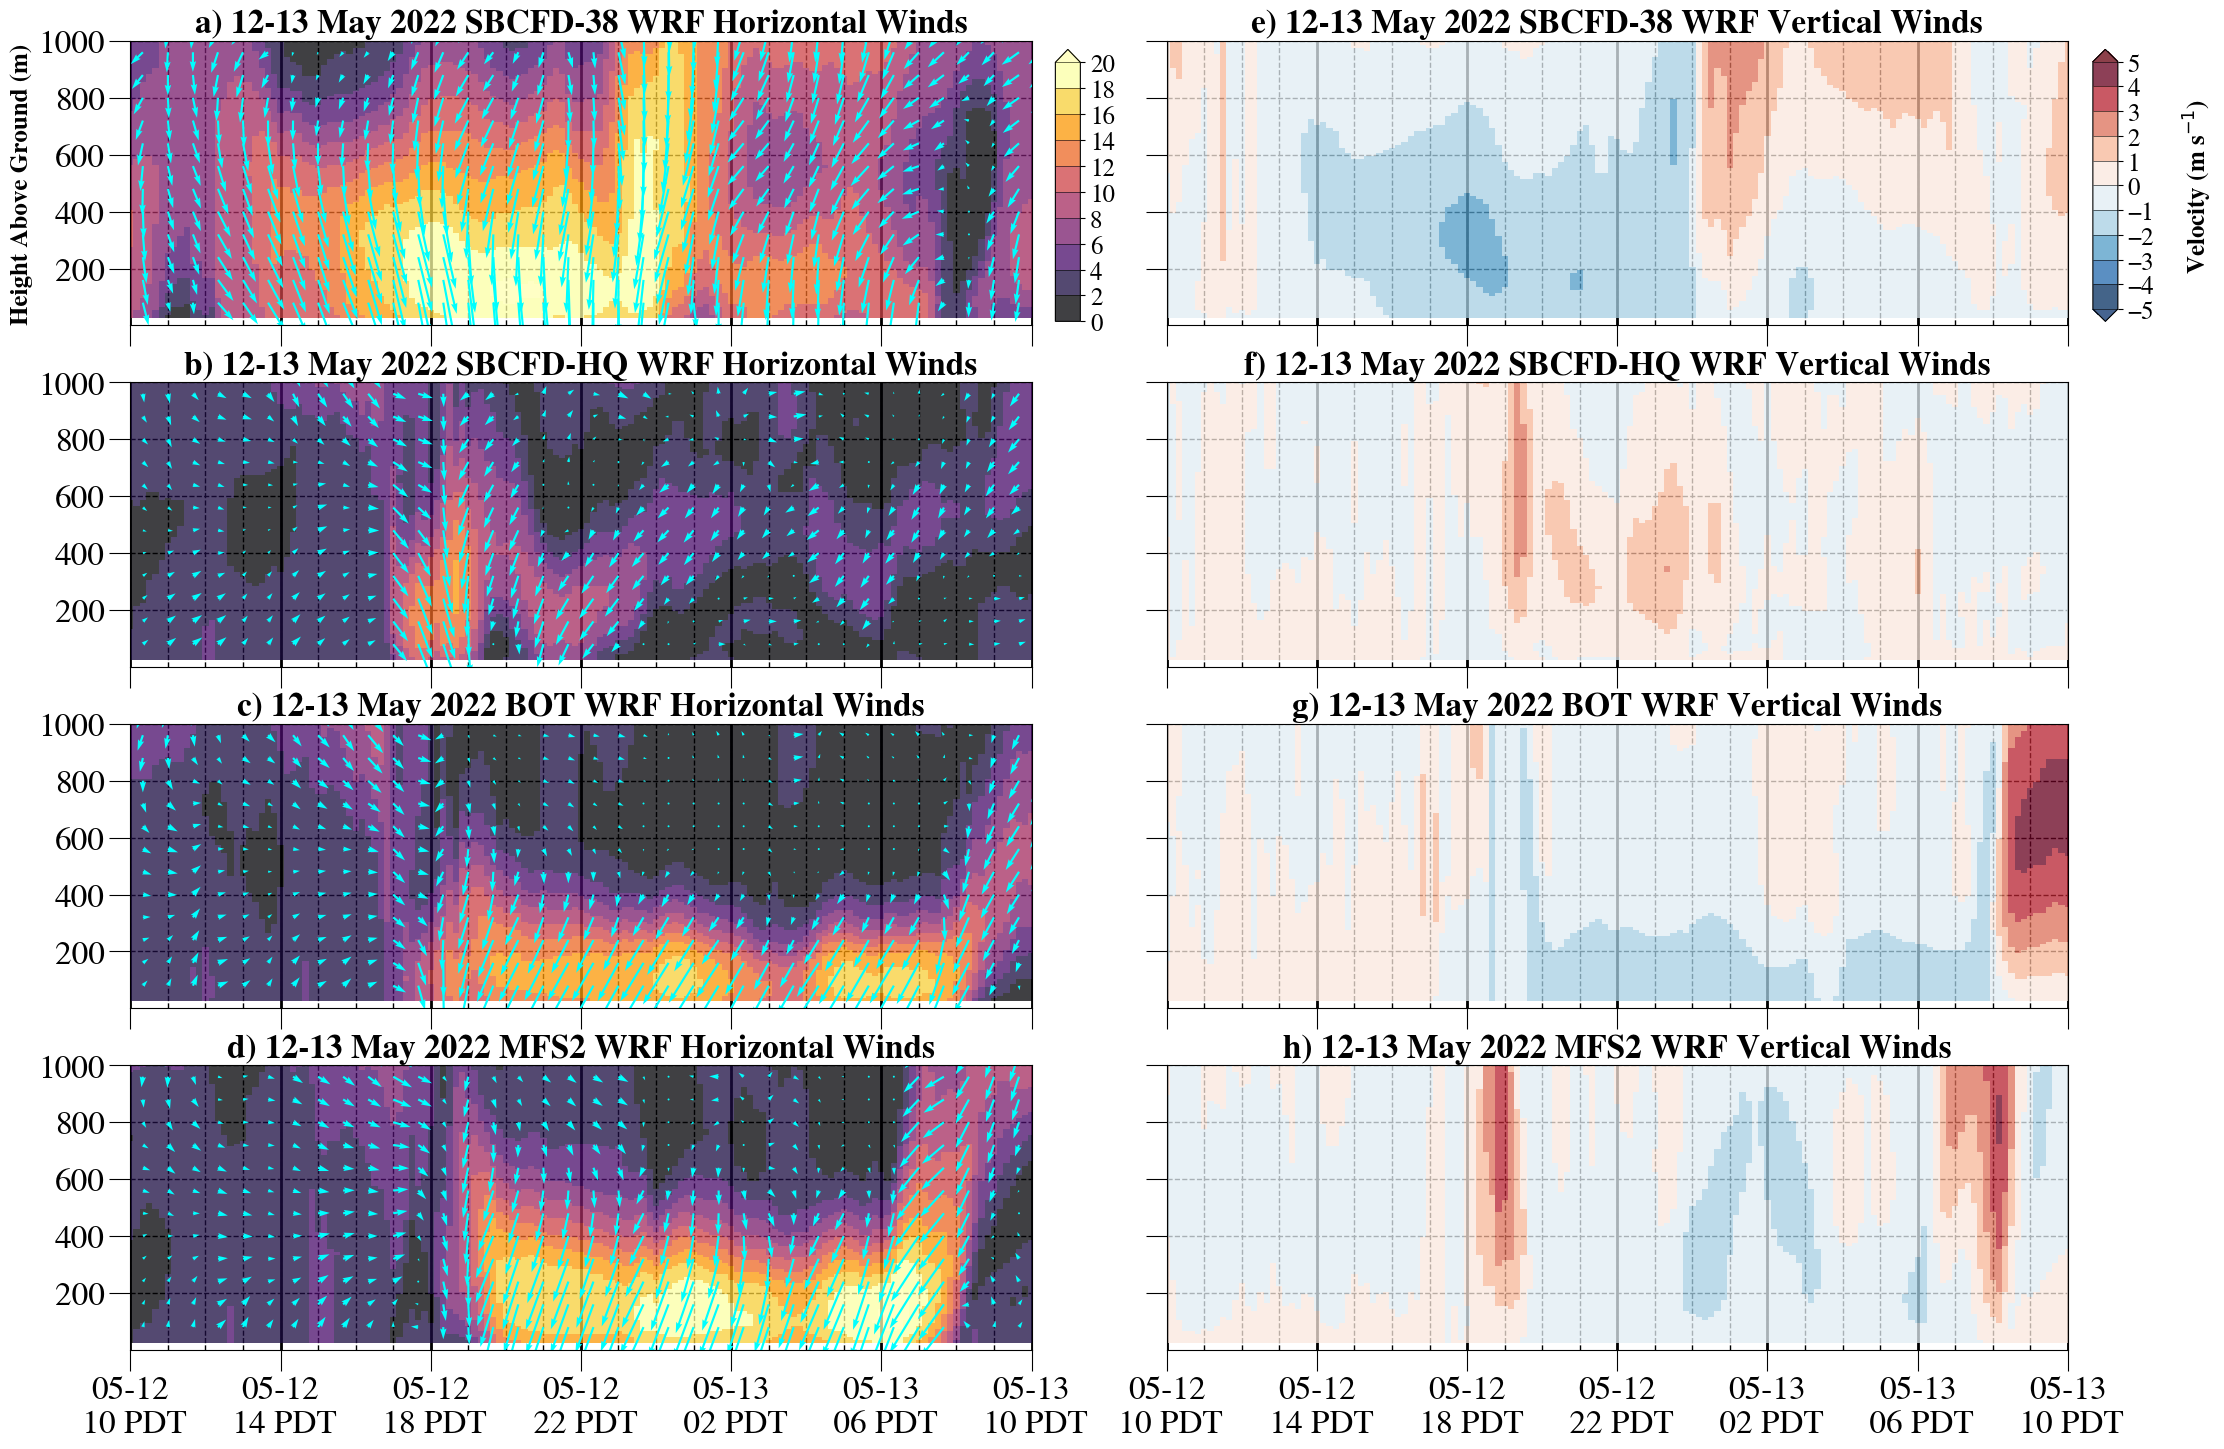

In [9]:
#----------------------------------------------------------------------------------------------------------------------
#Key word arguements for the created figure, line plot timeseries, and scatter plot timeseries
fig_kwargs = dict(nrows=4, ncols=2, sharex='all', figsize=(25,17), gridspec_kw=dict(hspace=0.2, wspace=0.15))

#Define font dictionaries for plotting
fontdict_xtick_labels  = {'fontsize': 24, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}
fontdict_ytick_labels  = {'fontsize': 24, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}
fontdict_xaxis_labels  = {'fontsize': 24, 'fontweight': 'bold',   'fontname': 'Nimbus Roman'}
fontdict_yaxis_labels  = {'fontsize': 18, 'fontweight': 'bold',   'fontname': 'Nimbus Roman'}
fontdict_title_labels  = {'fontsize': 24, 'fontweight': 'bold',   'fontname': 'Nimbus Roman'}
fontdict_text_color_bar = {'fontsize': 18, 'fontweight': 'bold', 'fontname': 'Nimbus Roman'}
fontdict_legend_labels = {'size': 20, 'weight': 'bold', 'family':'Nimbus Roman'}

#Create figure and axis for plotting
fig, axs = plt.subplots(**fig_kwargs)

inset_annotation_str_list = ['a) 12-13 May 2022 SBCFD-38 WRF Horizontal Winds', 'e) 12-13 May 2022 SBCFD-38 WRF Vertical Winds',
                             'b) 12-13 May 2022 SBCFD-HQ WRF Horizontal Winds', 'f) 12-13 May 2022 SBCFD-HQ WRF Vertical Winds',
                             'c) 12-13 May 2022 BOT WRF Horizontal Winds',      'g) 12-13 May 2022 BOT WRF Vertical Winds',
                             'd) 12-13 May 2022 MFS2 WRF Horizontal Winds',     'h) 12-13 May 2022 MFS2 WRF Vertical Winds']

inset_bbox_list = [(0.58, 0.86, 0.42, 0.14), (0.58, 0.86, 0.42, 0.14),
                   (0.55, 0.86, 0.45, 0.14), (0.55, 0.86, 0.45, 0.14),
                   (0.51, 0.86, 0.49, 0.14), (0.51, 0.86, 0.49, 0.14),
                   (0.56, 0.88, 0.44, 0.12), (0.56, 0.88, 0.44, 0.12)]

lidar_heights_list = [height_2d]*8

lidar_times_list   = [time_2d]*8

lidar_wind_speed_list = [sjsu_xy_wind,  sjsu_z_wind, 
                         ncar_xy_wind,  ncar_z_wind,
                         und_xy_wind,   und_z_wind, 
                         uwow_xy_wind,  uwow_z_wind]

lidar_wind_u_list     = [sjsu_x_wind, [], 
                         ncar_x_wind, [], 
                         und_x_wind,  [],
                         uwow_x_wind, []]

lidar_wind_v_list     = [sjsu_y_wind, [], 
                         ncar_y_wind, [], 
                         und_y_wind,  [],
                         uwow_y_wind, []]

barb_density_height_list = [8, [], 
                            8,  [], 
                            8,  [],
                            8,  []]

barb_density_time_list   = [4, [], 
                            4,  [], 
                            4,  [],
                            4,  []]
#----------------------------------------------------------------------------------------------------------------------
#For each axis we have, do the following:
for ax_index, ax in enumerate(axs.flatten()):
    
    #x-axis customizations for last axis
    xticks_utc = pd.date_range(start='2022-05-12 17:00', end='2022-05-13 17:00', freq='1H')
    xticks_pdt = xticks_utc - np.timedelta64(7, 'h')
    xticklabels = [f'{str(xtick_pdt)[5:10]}\n{str(xtick_pdt)[10:13]} PDT' for xtick_pdt in xticks_pdt]
    ax.set_xlim([xticks_utc[0],xticks_utc[-1]])
    ax.set_xticks(xticks_utc[::4])
    ax.set_xticklabels(xticklabels[::4], fontdict=fontdict_xtick_labels)
        
    #y-axis customizations for all axes
    y_min  = 200
    y_max  = 1000
    y_step = 200
    yticks = np.arange(y_min, y_max+y_step, y_step)
    ax.set_yticks(yticks)
    ax.set_ylim([0, y_max])
        
    #Plot a horizontal lines that spans the entire x-axis for each of the y_ticks we have
    for y_tick in yticks:
        ax.axhline(y=y_tick, xmin=0, xmax=1, color='black', linestyle='--', linewidth=1, zorder=1)

    #Plot a vertical line that spands the entire y-axis for every hour
    for xtick_utc in xticks_utc:
        ax.axvline(x=xtick_utc, ymin=0, ymax=1, color='black', linestyle='--', linewidth=1, zorder=1)

    #Make vertical line thicker where hours when we have a xticklabel
    for xtick_utc in xticks_utc[::4]:
        ax.axvline(x=xtick_utc, ymin=0, ymax=1, color='black', linestyle='-', linewidth=2, zorder=1)
    
    #Add title
    ax.set_title(inset_annotation_str_list[ax_index], **fontdict_title_labels)
    
    #Add ticks longer
    ax.tick_params(axis='both', which='major', length=15)
    
    if ax_index == 0:
        ax.set_ylabel('Height Above Ground (m)', **fontdict_yaxis_labels)
#----------------------------------------------------------------------------------------------------------------------        
    #If the ax index is even, we are plotting XY LiDAR data
    if ax_index % 2 == 0:
    
        #Define colorbar levels and colorbar norms for plotting XY data
        #https://stackoverflow.com/questions/48613920/use-of-extend-in-a-pcolormesh-plot-with-discrete-colorbar
        #https://mycarta.wordpress.com/2012/10/14/the-rainbow-is-deadlong-live-the-rainbow-part-4-cie-lab-heated-body/
        xy_level_min  = 0
        xy_level_max  = 20
        xy_level_step = 2
        xy_levels = np.arange(xy_level_min,xy_level_max+xy_level_step,xy_level_step)
        xy_cmap   = plt.get_cmap('inferno').copy()
        xy_cmap.set_extremes(under='None', over='#ffffb2', bad='None')        
        xy_norm   = mplc.BoundaryNorm(xy_levels, ncolors=xy_cmap.N, clip=False)
        
        #Plot pcolormesh
        xy_pcolormesh = ax.pcolormesh(lidar_times_list[ax_index], 
                                      lidar_heights_list[ax_index], 
                                      lidar_wind_speed_list[ax_index], 
                                      shading='nearest', cmap=xy_cmap, norm=xy_norm, alpha=0.75)
        #Plot quiver
        barbs = ax.quiver(lidar_times_list[ax_index][::barb_density_height_list[ax_index], ::barb_density_time_list[ax_index]], 
                          lidar_heights_list[ax_index][::barb_density_height_list[ax_index], ::barb_density_time_list[ax_index]], 
                          lidar_wind_u_list[ax_index][::barb_density_height_list[ax_index], ::barb_density_time_list[ax_index]],
                          lidar_wind_v_list[ax_index][::barb_density_height_list[ax_index], ::barb_density_time_list[ax_index]],
                          scale=30*10, scale_units='width', color='cyan')

        #Add y-tick labels for even subplots only
        ax.set_yticklabels(yticks, **fontdict_ytick_labels)
#----------------------------------------------------------------------------------------------------------------------    
    #Else, we are plotting Z LiDAR data
    else:
        
        #Define colorbar levels and colorbar norms for plotting Z data
        #https://stackoverflow.com/questions/48613920/use-of-extend-in-a-pcolormesh-plot-with-discrete-colorbar
        #https://mycarta.wordpress.com/2012/10/14/the-rainbow-is-deadlong-live-the-rainbow-part-4-cie-lab-heated-body/
        z_level_min  = -5
        z_level_max  = 5
        z_level_step = 1
        z_levels = np.arange(z_level_min,z_level_max+z_level_step,z_level_step)
        z_cmap = plt.get_cmap('RdBu_r').copy()
        z_cmap.set_extremes(under='#08306b', over='#67000d', bad='None')        
        z_norm   = mplc.BoundaryNorm(z_levels, ncolors=z_cmap.N, clip=False)
        
        #Plot pcolormesh
        z_pcolormesh = ax.pcolormesh(lidar_times_list[ax_index], 
                                     lidar_heights_list[ax_index], 
                                     lidar_wind_speed_list[ax_index], 
                                     shading='nearest', cmap=z_cmap, norm=z_norm, alpha=0.75)
        
        #Remove y-tick labels for odd subplots only
        ax.set_yticklabels([])
#----------------------------------------------------------------------------------------------------------------------        
#Create a colorbar axis outside the figure for horizontal velocity
xy_cax  = fig.add_axes([0.495, 0.715, 0.01, 0.16])  # [left, bottom, width, height]
xy_cbar = fig.colorbar(xy_pcolormesh, cax=xy_cax, orientation='vertical', spacing='uniform', extend='max', drawedges=True, ticks=xy_levels[::1])

#Set font for vertical velocity colorbar tick lables
#https://stackoverflow.com/questions/7257372/set-font-properties-to-tick-labels-with-matplot-lib/7280803
ticks_font = mplf.FontProperties(family='Nimbus Roman', style='normal', size=18, weight='normal', stretch='normal')
for label in xy_cbar.ax.get_yticklabels():
    label.set_fontproperties(ticks_font)  
    
#Create a colorbar axis outside the figure for vertical velocity
z_cax  = fig.add_axes([0.91, 0.715, 0.01, 0.16])  # [left, bottom, width, height]
z_cbar = fig.colorbar(z_pcolormesh, cax=z_cax, orientation='vertical', spacing='uniform', extend='both', drawedges=True, ticks=z_levels[::1])
z_cbar.set_label('Velocity (m s$^{-1}$)', color='black', labelpad=20, **fontdict_text_color_bar)

#Set font for vertical velocity colorbar tick lables
#https://stackoverflow.com/questions/7257372/set-font-properties-to-tick-labels-with-matplot-lib/7280803
ticks_font = mplf.FontProperties(family='Nimbus Roman', style='normal', size=18, weight='normal', stretch='normal')
for label in z_cbar.ax.get_yticklabels():
    label.set_fontproperties(ticks_font)
#----------------------------------------------------------------------------------------------------------------------
#Save figure
plt.savefig('./figures/figure_09_wrf_lidar_winds.png', bbox_inches='tight', dpi=500)
#----------------------------------------------------------------------------------------------------------------------

## **Plot WRF simulated vertical wind profiles for KBFL**
#### Notes
> - #### See in-line comments for additional details.

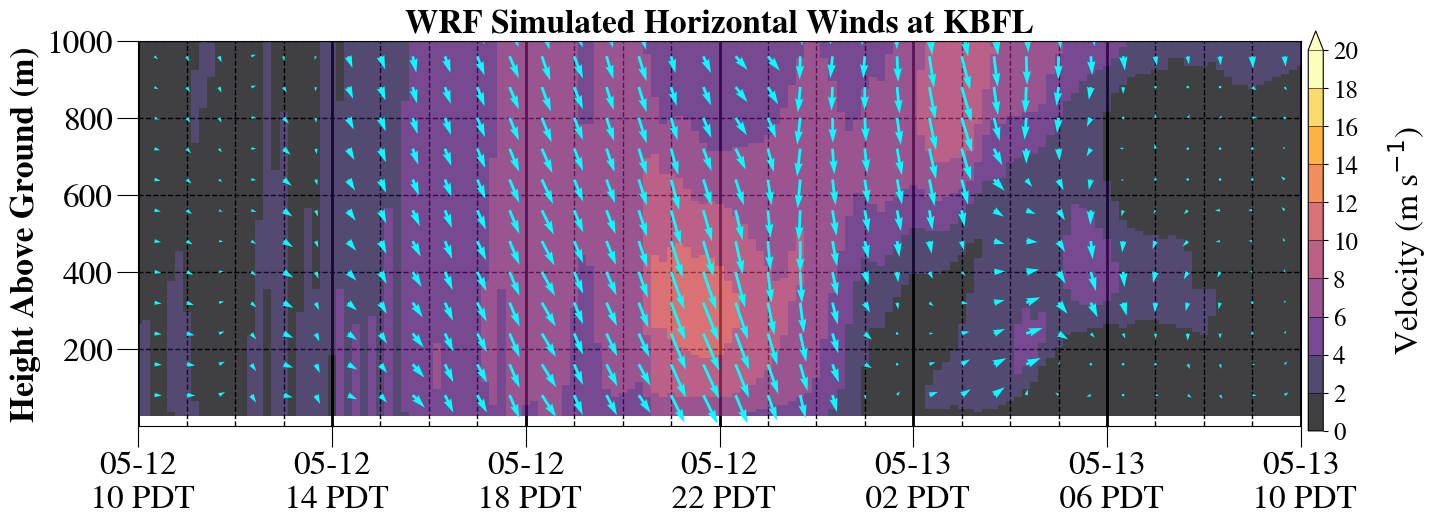

In [10]:
#----------------------------------------------------------------------------------------------------------------------
#Create figure and axis for plotting
fig, ax = plt.subplots(figsize=(15,5))

#Define font cusomization items
fontdict_xtick_labels  = {'fontsize': 24, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}
fontdict_ytick_labels  = {'fontsize': 24, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}
fontdict_xaxis_labels  = {'fontsize': 24, 'fontweight': 'bold',   'fontname': 'Nimbus Roman'}
fontdict_yaxis_labels  = {'fontsize': 24, 'fontweight': 'bold',   'fontname': 'Nimbus Roman'}
fontdict_title_labels  = {'fontsize': 24, 'fontweight': 'bold',   'fontname': 'Nimbus Roman'}
fontdict_text_color_bar = {'fontsize': 24, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}
fontdict_legend_labels = {'size': 20, 'weight': 'bold', 'family':'Nimbus Roman'}

#Add title
ax.set_title('WRF Simulated Horizontal Winds at KBFL', **fontdict_title_labels)

#Make ticks longer
ax.tick_params(axis='both', which='major', length=15)

#Define xticks (time)
xticks_utc = pd.date_range(start='2022-05-12 17:00', end='2022-05-13 17:00', freq='1H')
xticks_pdt = xticks_utc - np.timedelta64(7, 'h')
xticklabels = [f'{str(xtick_pdt)[5:10]}\n{str(xtick_pdt)[10:13]} PDT' for xtick_pdt in xticks_pdt]

#x-axis customizations
ax.set_xlim([xticks_utc[0],xticks_utc[-1]])
ax.set_xticks(xticks_utc[::4])
ax.set_xticklabels(xticklabels[::4], fontdict=fontdict_xtick_labels)

#y-axis customizations
y_min  = 200
y_max  = 1000
y_step = 200
yticks = np.arange(y_min, y_max+y_step, y_step)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, **fontdict_ytick_labels)
ax.set_ylim([0, y_max])
ax.set_ylabel('Height Above Ground (m)', **fontdict_yaxis_labels)

#Plot a horizontal lines that spans the entire x-axis for each of the y_ticks we have
for y_tick in yticks:
    ax.axhline(y=y_tick, xmin=0, xmax=1, color='black', linestyle='--', linewidth=1, zorder=1)

#Plot a vertical line that spands the entire y-axis for every hour
for xtick_utc in xticks_utc:
    ax.axvline(x=xtick_utc, ymin=0, ymax=1, color='black', linestyle='--', linewidth=1, zorder=1)

#Make vertical line thicker where hours when we have a xticklabel
for xtick_utc in xticks_utc[::4]:
    ax.axvline(x=xtick_utc, ymin=0, ymax=1, color='black', linestyle='-', linewidth=2, zorder=1)

#Define colorbar levels and colorbar norms for plotting XY data
#https://stackoverflow.com/questions/48613920/use-of-extend-in-a-pcolormesh-plot-with-discrete-colorbar
#https://mycarta.wordpress.com/2012/10/14/the-rainbow-is-deadlong-live-the-rainbow-part-4-cie-lab-heated-body/
level_min  = 0
level_max  = 20
level_step = 2
levels = np.arange(level_min,level_max+level_step,level_step)
cmap   = plt.get_cmap('inferno').copy()
cmap.set_extremes(under='None', over='#ffffb2', bad='None')        
norm   = mplc.BoundaryNorm(levels, ncolors=cmap.N, clip=False)

#Plot pcolormesh
pcolormesh = ax.pcolormesh(time_2d, height_2d, kbfl_xy_wind, shading='nearest', cmap=cmap, norm=norm, alpha=0.75)
            
#Create a colorbar axis outside the figure for vertical velocity
cax  = fig.add_axes([0.905, 0.10, 0.01, 0.80])  # [left, bottom, width, height]
cbar = fig.colorbar(pcolormesh, cax=cax, orientation='vertical', spacing='uniform', extend='max', drawedges=True, ticks=levels[::1])
cbar.set_label('Velocity (m s$^{-1}$)', color='black', labelpad=20, **fontdict_text_color_bar)

#Set font for vertical velocity colorbar tick lables
#https://stackoverflow.com/questions/7257372/set-font-properties-to-tick-labels-with-matplot-lib/7280803
ticks_font = mplf.FontProperties(family='Nimbus Roman', style='normal', size=18, weight='normal', stretch='normal')
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(ticks_font)
    
#Plot quiver
barbs = ax.quiver(time_2d[::8, ::4], 
                  height_2d_2d[::8, ::4], 
                  kbfl_x_wind[::8, ::4],
                  kbfl_y_wind[::8, ::4],
                  scale=30*10, scale_units='width', color='cyan')
#----------------------------------------------------------------------------------------------------------------------
#Save figure
plt.savefig('./figures/figure_10_wrf_kbfl.png', bbox_inches='tight', dpi=500)
#----------------------------------------------------------------------------------------------------------------------